# Datasets using `tf.data.Dataset`

## Test example

Once the feedloop is setup as a python generator, it can be converted in to a tensorflow `Dataset` object for optimal ingestion into Keras. We exemplify this here, using a generator that reads tiles in TIFF format from disk:

In [1]:
import pathlib
import tensorflow as tf
import xarray as xr

In [2]:
# path with TIFF files
tile_path = "./retiled_test"

In [3]:
# generator - much simplified version of the feed loop, reading cutouts from disk
def get_tile(tile_path):
    # string input is passed by tf as byte object, need to decode
    tile_path = tile_path.decode() if isinstance(tile_path, bytes) else tile_path
    tile_path = pathlib.Path(tile_path)
    for file in tile_path.glob("*.tif"):
        yield xr.open_rasterio(file).data

In [4]:
# testing the iterator
iterator = get_tile(tile_path)
element = next(iterator)
element.dtype, element.shape

(dtype('uint16'), (3, 20, 20))

In [5]:
# set up Dataset object
ds = tf.data.Dataset.from_generator(
    get_tile, 
    args=[tile_path], 
    output_types=tf.int16, 
    output_shapes=(3, 20, 20)
)
ds

<FlatMapDataset shapes: (3, 20, 20), types: tf.int16>

In [6]:
# shuffle elements with a buffer of 100, making batches with 20 cutouts each
# (in first batch we can have elements from the first 120 files)
batches = ds.shuffle(buffer_size=100).batch(20, drop_remainder=True)
batches

<BatchDataset shapes: (20, 3, 20, 20), types: tf.int16>

## Feed loop for VAE network

We implement the real feedloop using `xarray`:

In [2]:
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import rioxarray as rioxr

from memory_profiler import memory_usage

In [3]:
class Dataset:
    
    def __init__(self, tile_list, cutout_size, offset=0, stride=None, num_tiles=None, shuffle_tiles=False):
        self.cutout_size = cutout_size
        self.stride = stride if stride is not None else self.cutout_size
        _num_tiles = num_tiles if num_tiles is not None else len(tile_list)
        self.tiles = random.sample(tile_list, _num_tiles) if shuffle_tiles else tile_list[:_num_tiles]
        if offset >= cutout_size:
            raise ValueError(
                "offset larger than window size - set "
                "offset to {}".format(sizeCutOut%offset)
            )
        self.offset = offset
        
        self.mask = None
        self.buffer = None
        self.invert = None
        self.all_touched = None
    
    def set_mask(self, geometry, crs, buffer=None, invert=False, all_touched=False):
        """ Mask a selection of the pixels using a geometry."""
        self.mask = gpd.GeoSeries({"geometry": geometry}, crs=crs)
        self.buffer = buffer if buffer is not None else 0
        self.invert = invert
        self.all_touched = all_touched
    
    def to_tf(self):
        """ Obtain dataset as a tensorflow `Dataset` object. """
        ds = tf.data.Dataset.from_generator(
            self._generate_cutouts,  
            output_types=(tf.float64, tf.float64, tf.float32), 
            output_shapes=(
                None,  # x
                None,  # y
                (None, None, self.cutout_size, self.cutout_size)  # samples, bands, x_win, y_win
            )
        )
        return ds.flat_map(lambda x,y,z: tf.data.Dataset.from_tensor_slices((x,y,z)))

    def _generate_cutouts(self):
        """ 
        Iterate over (a selection of) the tiles yielding all 
        cutouts for each of them.
        """
        for tile in self.tiles:
            
            print(f"Reading tile {tile}!")
            
            # read tile
            da = rioxr.open_rasterio(tile)
            
            if self.mask is not None:
                mask = self.mask.to_crs(da.spatial_ref.crs_wkt)
                geometry = mask.unary_union.buffer(self.buffer)
                da = da.rio.clip([geometry], drop=True, invert=self.invert, all_touched=self.all_touched)
            
            # apply offset
            da = da.shift(x=self.offset, y=self.offset)  # only shift data, not coords
            da['x'] = da.x.shift(x=self.offset)
            da['y'] = da.y.shift(y=self.offset)

            # generate windows
            da = da.rolling(x=self.cutout_size, y=self.cutout_size)
            da = da.construct({'x': 'x_win', 'y': 'y_min'}, stride=self.stride)

            # drop NaN-containing windows
            da = da.stack(sample=('x', 'y'))
            da = da.dropna(dim='sample', how='any')
            yield (da.sample.coords['x'], 
                   da.sample.coords['y'], 
                   da.data.transpose(3, 0, 1, 2))  # samples, bands, x_win, y_win

In [4]:
# list of all tiles available
tile_list = [t for t in pathlib.Path('./test').glob('tile_*.tif')]
len(tile_list)

20

In [9]:
ds = Dataset(
    tile_list=tile_list,
    cutout_size=20,
    num_tiles=2
)
ds.set_mask(gdf_proj.unary_union, crs=gdf_proj.crs)
dataset = ds.to_tf()
dataset

<FlatMapDataset shapes: (<unknown>, <unknown>, (None, 20, 20)), types: (tf.float64, tf.float64, tf.float32)>

In [10]:
batches = dataset.shuffle(buffer_size=500000).batch(250000, drop_remainder=True)
batches

<BatchDataset shapes: (<unknown>, <unknown>, (250000, None, 20, 20)), types: (tf.float64, tf.float64, tf.float32)>

In [11]:
def run(batches):
    for x, y, data in batches:
        print(x.shape, y.shape, data.shape)

# run(batches)

In [12]:
%%time
memory = memory_usage((run, (batches,)), interval=0.01)

Reading tile test/tile_1.tif!
Reading tile test/tile_3.tif!
(250000,) (250000,) (250000, 3, 20, 20)
CPU times: user 33.5 s, sys: 15.5 s, total: 49 s
Wall time: 51.9 s


Text(0.5, 0, 'Time step')

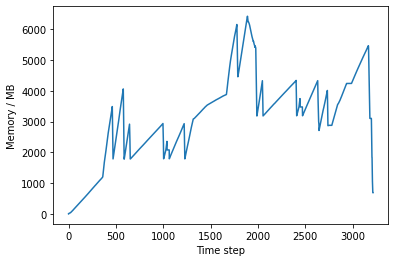

In [11]:
_memory = np.array(memory) - memory[0]
plt.plot(_memory)
plt.ylabel("Memory / MB")
plt.xlabel("Time step")

## TODO: 
* leave band axis at the end (when transposing):
```python
            ...
            yield (da.sample.coords['x'], 
                   da.sample.coords['y'], 
                   da.data.transpose(3, 1, 2, 0))  # samples, x_win, y_win, bands
```


* add selection of band:
    - add band argument in `__init__`, take integer (band number `x`), string (band name) or iterable (list of bands to select).
    - filter bands immediately using `da.sel(bands=)` or `da.isel(bands=)`
* add filtering using shapefiles (see below)
* problem: what if cell is empty after applying mask?

In [13]:
import geopandas as gpd
import rioxarray as rioxr  # use rioxarray, it has clip method

# draft method to add mask
class Test():
    def __init__(self):
        self.mask = None
        self.buffer = None
        self.invert = None
        self.all_touched = None

    def set_mask(self, geometry, crs, buffer=None, invert=False, all_touched=False):

        self.mask = gpd.GeoSeries({"geometry": geometry}, crs=crs)
        self.buffer = buffer if buffer is not None else 0
        self.invert = invert
        self.all_touched = all_touched
        
    def _generate_cutouts(self, tile):
        
        da = rioxr.open_rasterio(tile).astype("float32")  # needed to mask with NaN's
        mask = self.mask.to_crs(da.spatial_ref.crs_wkt)
        geometry = mask.unary_union.buffer(self.buffer)
        self.da = da.rio.clip([geometry], drop=True, invert=self.invert, all_touched=self.all_touched)


In [14]:
tile = './test/tile_1.tif'

In [1]:
import geopandas as gpd
# get test geometry
gdf = gpd.read_file("ne_10m_antarctic_ice_shelves_polys/ne_10m_antarctic_ice_shelves_polys.shp")
gdf_proj = gdf.to_crs("EPSG:3031")
gdf_proj

,recnum,featurecla,name,scalerank,min_zoom,geometry
0,154,Antarctic Ice Shelf,Ross Ice Shelf,0,0.0,"POLYGON ((-482043.174 -1232376.050, -484553.67..."
1,153,Antarctic Ice Shelf,None,0,0.0,"MULTIPOLYGON (((2187528.101 -1323487.409, 2186..."
2,152,Antarctic Ice Shelf,None,0,0.0,"POLYGON ((-846942.516 649439.279, -846941.132 ..."
3,151,Antarctic Ice Shelf,None,0,0.0,"MULTIPOLYGON (((-897871.638 926583.922, -89787..."
4,150,Antarctic Ice Shelf,Rennick Glacier,0,0.0,"POLYGON ((684804.517 -2061044.749, 684930.093 ..."
...,...,...,...,...,...,...
154,5,Antarctic Ice Shelf,None,0,0.0,"POLYGON ((2163265.919 1442822.327, 2164905.926..."
155,4,Antarctic Ice Shelf,None,0,0.0,"POLYGON ((2137620.458 1307430.464, 2138204.150..."
156,3,Antarctic Ice Shelf,None,0,0.0,"POLYGON ((2141172.666 1323571.942, 2140152.597..."
157,2,Antarctic Ice Shelf,None,0,0.0,"POLYGON ((2217980.688 522214.817, 2218197.452 ..."


In [35]:
# geometry from dataframe union
geometry = gdf_proj.unary_union

test = Test()
test.set_mask(geometry, crs=gdf_proj.crs)
test._generate_cutouts(tile)
test.da

<xarray.DataArray (band: 3, y: 9853, x: 9267)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.652e+05 -3.652e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.561e+06 -1.561e+06
  * band         (band) int64 1 2 3
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [36]:
# single polygon
from shapely.geometry.polygon import Polygon

da = rioxr.open_rasterio(tile)
polygon = Polygon.from_bounds(*da.rio.bounds())
geometry = gdf_proj[gdf_proj.intersects(polygon)].geometry[95]

test = Test()
test.set_mask(geometry, crs=gdf_proj.crs)
test._generate_cutouts(tile)
test.da

<xarray.DataArray (band: 3, y: 9853, x: 9267)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.652e+05 -3.652e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.561e+06 -1.561e+06
  * band         (band) int64 1 2 3
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref